## 币安做空超涨做多超跌策略的优化

原有研究报告地址：https://www.fmz.com/digest-topic/5294 可以先看一遍，这篇文章不会有重复的内容。重点介绍了第二个策略的优化过程。经过优化策略改进明显，建议根据这篇文章进行策略的升级。回测引擎加入了手续费的统计。

In [1]:
# 需要导入的库
import pandas as pd
import requests
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
%matplotlib inline

In [2]:
symbols = ['ETH', 'BCH', 'XRP', 'EOS', 'LTC', 'TRX', 'ETC', 'LINK', 'XLM', 'ADA', 'XMR', 'DASH', 'ZEC', 'XTZ', 'BNB', 'ATOM', 'ONT', 'IOTA', 'BAT', 'VET', 'NEO', 'QTUM', 'IOST']

In [3]:
price_usdt = pd.read_csv('https://www.fmz.com/upload/asset/20227de6c1d10cb9dd1.csv ', index_col = 0)
price_usdt.index = pd.to_datetime(price_usdt.index)

In [170]:
price_usdt_norm = price_usdt/price_usdt.fillna(method='bfill').iloc[0,]

In [171]:
price_usdt_btc = price_usdt.divide(price_usdt['BTC'],axis=0)
price_usdt_btc_norm = price_usdt_btc/price_usdt_btc.fillna(method='bfill').iloc[0,]

In [225]:
class Exchange:
    
    def __init__(self, trade_symbols, leverage=20, commission=0.00005,  initial_balance=10000, log=False):
        self.initial_balance = initial_balance #初始的资产
        self.commission = commission
        self.leverage = leverage
        self.trade_symbols = trade_symbols
        self.date = ''
        self.log = log
        self.df = pd.DataFrame(columns=['margin','total','leverage','realised_profit','unrealised_profit'])
        self.account = {'USDT':{'realised_profit':0, 'margin':0, 'unrealised_profit':0, 'total':initial_balance, 'leverage':0, 'fee':0}}
        for symbol in trade_symbols:
            self.account[symbol] = {'amount':0, 'hold_price':0, 'value':0, 'price':0, 'realised_profit':0, 'margin':0, 'unrealised_profit':0,'fee':0}
            
    def Trade(self, symbol, direction, price, amount, msg=''):
        if self.date and self.log:
            print('%-20s%-5s%-5s%-10.8s%-8.6s %s'%(str(self.date), symbol, 'buy' if direction == 1 else 'sell', price, amount, msg))
            
        cover_amount = 0 if direction*self.account[symbol]['amount'] >=0 else min(abs(self.account[symbol]['amount']), amount)
        open_amount = amount - cover_amount
        
        self.account['USDT']['realised_profit'] -= price*amount*self.commission #扣除手续费
        self.account['USDT']['fee'] += price*amount*self.commission
        self.account[symbol]['fee'] += price*amount*self.commission
        
        if cover_amount > 0: #先平仓
            self.account['USDT']['realised_profit'] += -direction*(price - self.account[symbol]['hold_price'])*cover_amount  #利润
            self.account['USDT']['margin'] -= cover_amount*self.account[symbol]['hold_price']/self.leverage #释放保证金
            
            self.account[symbol]['realised_profit'] += -direction*(price - self.account[symbol]['hold_price'])*cover_amount
            self.account[symbol]['amount'] -= -direction*cover_amount
            self.account[symbol]['margin'] -=  cover_amount*self.account[symbol]['hold_price']/self.leverage
            self.account[symbol]['hold_price'] = 0 if self.account[symbol]['amount'] == 0 else self.account[symbol]['hold_price']
            
        if open_amount > 0:
            total_cost = self.account[symbol]['hold_price']*direction*self.account[symbol]['amount'] + price*open_amount
            total_amount = direction*self.account[symbol]['amount']+open_amount
            
            self.account['USDT']['margin'] +=  open_amount*price/self.leverage            
            self.account[symbol]['hold_price'] = total_cost/total_amount
            self.account[symbol]['amount'] += direction*open_amount
            self.account[symbol]['margin'] +=  open_amount*price/self.leverage
            
        self.account[symbol]['unrealised_profit'] = (price - self.account[symbol]['hold_price'])*self.account[symbol]['amount']
        self.account[symbol]['price'] = price
        self.account[symbol]['value'] = abs(self.account[symbol]['amount'])*price
        
        return True
    
    def Buy(self, symbol, price, amount, msg=''):
        self.Trade(symbol, 1, price, amount, msg)
        
    def Sell(self, symbol, price, amount, msg=''):
        self.Trade(symbol, -1, price, amount, msg)
        
    def Update(self, date, close_price): #对资产进行更新
        self.date = date
        self.close = close_price
        self.account['USDT']['unrealised_profit'] = 0
        for symbol in self.trade_symbols:
            if np.isnan(close_price[symbol]):
                continue
            self.account[symbol]['unrealised_profit'] = (close_price[symbol] - self.account[symbol]['hold_price'])*self.account[symbol]['amount']
            self.account[symbol]['price'] = close_price[symbol]
            self.account[symbol]['value'] = abs(self.account[symbol]['amount'])*close_price[symbol]
            self.account['USDT']['unrealised_profit'] += self.account[symbol]['unrealised_profit']
            if self.date.hour in [0,8,16]:
                pass
                self.account['USDT']['realised_profit'] += -self.account[symbol]['amount']*close_price[symbol]*0.01/100
        
        self.account['USDT']['total'] = round(self.account['USDT']['realised_profit'] + self.initial_balance + self.account['USDT']['unrealised_profit'],6)
        self.account['USDT']['leverage'] = round(self.account['USDT']['margin']/self.account['USDT']['total'],4)*self.leverage
        self.df.loc[self.date] = [self.account['USDT']['margin'],self.account['USDT']['total'],self.account['USDT']['leverage'],self.account['USDT']['realised_profit'],self.account['USDT']['unrealised_profit']]

**原来策略的表现，经过币种的筛选，表现的还不错，但是持仓依然很多,普遍在4倍左右**

原理：
- 1.更新行情和账户持仓，第一次运行会记录初始价格（新加入的币种按照加入时间计算）
- 2.更新指数，指数是山寨币-比特币价格指数 = mean(sum((山寨币价格/比特币价格)/(山寨币初始价格/比特币初始价格)))
- 3.根据偏离指数判断做多做空,根据偏离大小判断仓位
- 4.下单，下单量由冰山委托决定，按照对手价成交（买入用卖一价）。
- 5.再次循环

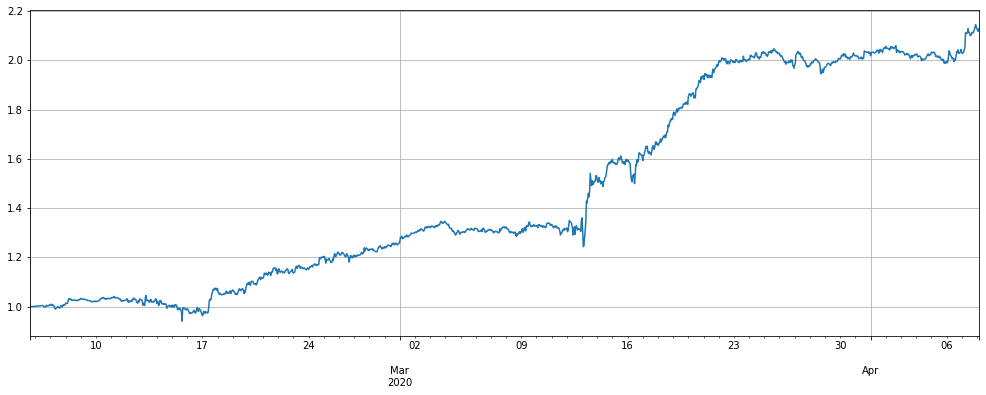

In [176]:
trade_symbols = list(set(symbols)-set(['LINK','XTZ','BCH', 'ETH']))#剩余的币种
price_usdt_btc_norm_mean = price_usdt_btc_norm[trade_symbols].mean(axis=1)
e = Exchange(trade_symbols,initial_balance=10000,commission=0.0005,log=False)
trade_value = 300
for row in price_usdt.iloc[:].iterrows():
    e.Update(row[0], row[1])
    empty_value = 0
    for symbol in trade_symbols:
        price = row[1][symbol]
        if np.isnan(price):
            continue
        diff = price_usdt_btc_norm.loc[row[0],symbol] - price_usdt_btc_norm_mean[row[0]]
        aim_value = -trade_value*round(diff/0.01,1)
        now_value = e.account[symbol]['value']*np.sign(e.account[symbol]['amount'])
        empty_value += now_value
        if aim_value - now_value > 20:
            e.Buy(symbol, price, round((aim_value - now_value)/price, 6),round(e.account[symbol]['realised_profit']+e.account[symbol]['unrealised_profit'],2))
        if aim_value - now_value < -20:
            e.Sell(symbol, price, -round((aim_value - now_value)/price, 6),round(e.account[symbol]['realised_profit']+e.account[symbol]['unrealised_profit'],2))
stragey_2b = e
(stragey_2b.df['total']/stragey_2b.initial_balance).plot(figsize=(17,6),grid = True);

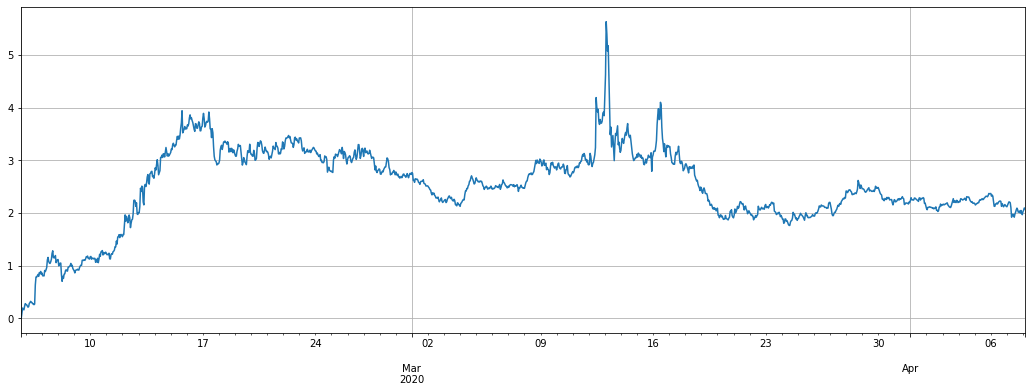

In [178]:
stragey_2b.df['leverage'].plot(figsize=(18,6),grid = True); #杠杆

In [177]:
pd.DataFrame(e.account).T.apply(lambda x:round(x,3)) #持仓

,realised_profit,margin,unrealised_profit,total,leverage,amount,hold_price,value,price
USDT,11912.530,2178.288,-627.858,21289.819,2.08,NaN,NaN,NaN,NaN
ETC,-2991.311,248.555,548.893,NaN,NaN,965.035,5.151,5520.000,5.720
XLM,385.387,232.370,-722.603,NaN,NaN,-106695.808,0.044,5370.000,0.050
XMR,732.287,246.264,-624.718,NaN,NaN,-95.657,51.489,5550.000,58.020
DASH,-1542.852,11.903,-1.935,NaN,NaN,-3.215,74.058,240.000,74.660
QTUM,3809.323,16.263,4.744,NaN,NaN,232.394,1.400,330.000,1.420
ATOM,1439.716,115.502,161.850,NaN,NaN,1021.867,2.261,2471.897,2.419
LTC,258.922,73.971,-80.578,NaN,NaN,-33.419,44.269,1560.000,46.680
BAT,1646.675,38.881,-32.371,NaN,NaN,-4759.107,0.163,810.000,0.170
NEO,1059.462,43.447,31.058,NaN,NaN,112.994,7.690,900.000,7.965


## 为什么要改进

原有最大的问题是最新价格和策略启动的初始价格对比，随着时间的增长，会越来越偏离，我们将会在这些币种上累计非常多的仓位。过滤币种最大的问题是我们根据以往的经验而未来仍然可能出现特特立独行的币种。下面就是不过滤的表现，实际上在trade_value=300时，策略中期已经爆仓，即使不爆仓，LINK、XTZ也分别持有了10000USDT以上的仓位，实在过于大了。因此必须在回测中解决这个问题，通过全币种的考验。

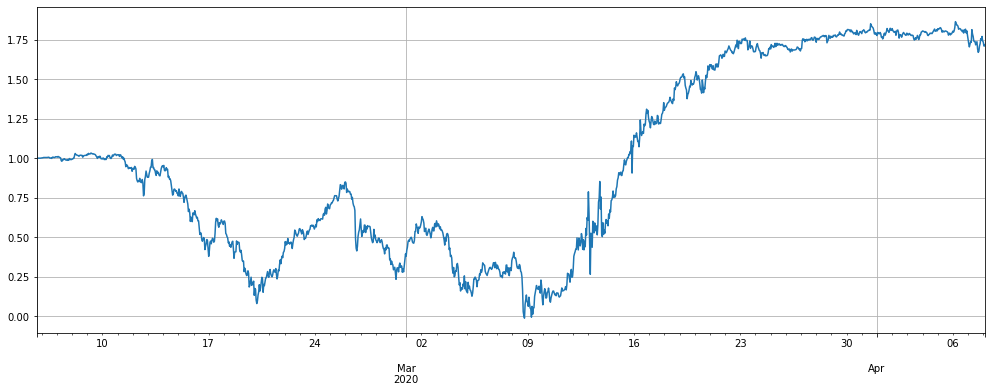

In [98]:
trade_symbols = list(set(symbols))#剩余的币种
price_usdt_btc_norm_mean = price_usdt_btc_norm[trade_symbols].mean(axis=1)
e = Exchange(trade_symbols,initial_balance=10000,commission=0.0005,log=False)
trade_value = 300
for row in price_usdt.iloc[:].iterrows():
    e.Update(row[0], row[1])
    empty_value = 0
    for symbol in trade_symbols:
        price = row[1][symbol]
        if np.isnan(price):
            continue
        diff = price_usdt_btc_norm.loc[row[0],symbol] - price_usdt_btc_norm_mean[row[0]]
        aim_value = -trade_value*round(diff/0.01,1)
        now_value = e.account[symbol]['value']*np.sign(e.account[symbol]['amount'])
        empty_value += now_value
        if aim_value - now_value > 20:
            e.Buy(symbol, price, round((aim_value - now_value)/price, 6),round(e.account[symbol]['realised_profit']+e.account[symbol]['unrealised_profit'],2))
        if aim_value - now_value < -20:
            e.Sell(symbol, price, -round((aim_value - now_value)/price, 6),round(e.account[symbol]['realised_profit']+e.account[symbol]['unrealised_profit'],2))
stragey_2c = e
(stragey_2c.df['total']/stragey_2c.initial_balance).plot(figsize=(17,6),grid = True);

In [99]:
pd.DataFrame(stragey_2c.account).T.apply(lambda x:round(x,3)) #最后持仓

,realised_profit,margin,unrealised_profit,total,leverage,amount,hold_price,value,price
USDT,9902.906,4027.894,-2697.901,17185.81,4.798,NaN,NaN,NaN,NaN
ETC,-4406.699,325.615,747.701,NaN,NaN,1269.231,5.131,7260.000,5.720
XLM,-702.556,161.279,-404.421,NaN,NaN,-72123.982,0.045,3630.000,0.050
XMR,-339.223,173.157,-346.855,NaN,NaN,-65.667,52.738,3810.000,58.020
QTUM,2954.343,97.759,114.817,NaN,NaN,1457.746,1.341,2070.000,1.420
ATOM,158.038,192.175,367.885,NaN,NaN,1740.959,2.208,4211.379,2.419
BAT,607.179,45.790,44.208,NaN,NaN,5640.423,0.162,960.000,0.170
VET,714.430,195.911,221.770,NaN,NaN,1053435.115,0.004,4140.000,0.004
TRX,-144.737,61.477,-60.454,NaN,NaN,-94091.904,0.013,1290.000,0.014
ADA,-472.192,53.348,43.039,NaN,NaN,30253.475,0.035,1110.000,0.037


In [25]:
((price_usdt_btc_norm.iloc[-1:] - price_usdt_btc_norm_mean[-1]).T) #各个币种偏离初始的情况

0,2020-04-08 03:00:00
BTC,0.165191
ETH,0.285501
BCH,-0.011090
XRP,0.101466
EOS,-0.044139
LTC,-0.005890
TRX,0.042733
ETC,-0.241950
LINK,0.442115
XLM,0.121035


既然问题的原因是和开始的价格进行比较，可能越偏越多。我们可以和过去一段时间的均线对比，回测全币种以下看看结果。

In [245]:
Alpha = 0.05
#price_usdt_btc_norm2 = price_usdt_btc/price_usdt_btc.rolling(20).mean() #普通均线
price_usdt_btc_norm2 = price_usdt_btc/price_usdt_btc.ewm(alpha=Alpha).mean() #这里和策略一致，用了EMA
trade_symbols = list(set(symbols))#全币种
price_usdt_btc_norm_mean = price_usdt_btc_norm2[trade_symbols].mean(axis=1)
e = Exchange(trade_symbols,initial_balance=10000,commission=0.0005,log=False)
trade_value = 300
for row in price_usdt.iloc[:].iterrows():
    e.Update(row[0], row[1])
    empty_value = 0
    for symbol in trade_symbols:
        price = row[1][symbol]
        if np.isnan(price):
            continue
        diff = price_usdt_btc_norm2.loc[row[0],symbol] - price_usdt_btc_norm_mean[row[0]]
        aim_value = -trade_value*round(diff/0.01,1)
        now_value = e.account[symbol]['value']*np.sign(e.account[symbol]['amount'])
        empty_value += now_value
        if aim_value - now_value > 20:
            e.Buy(symbol, price, round((aim_value - now_value)/price, 6),round(e.account[symbol]['realised_profit']+e.account[symbol]['unrealised_profit'],2))
        if aim_value - now_value < -20:
            e.Sell(symbol, price, -round((aim_value - now_value)/price, 6),round(e.account[symbol]['realised_profit']+e.account[symbol]['unrealised_profit'],2))
stragey_2d = e
#print(N,stragey_2d.df['total'][-1],pd.DataFrame(stragey_2d.account).T.apply(lambda x:round(x,3))['value'].sum())

策略表现完全达到了我们的预期，收益相差无几，在全币种原策略爆仓的局面也平滑过渡了，几乎没回撤，同样的开仓大小，杠杆几乎都在1倍以下，3.12暴跌的极端情况下也没超过4倍，这意味着我们可以加大trade_value，在同样的杠杆下，将收益再提高一倍。最终的持仓只有BCH超过1000USDT，十分良好。

为什么会降低了持仓，想象以下加入山寨币指数不变，一个币涨了100%，而且长期维持，原策略会长期持有300\*100 = 30000USDT的空单，而新策略会最终将基准价格追踪到最新价，最后会不持仓，

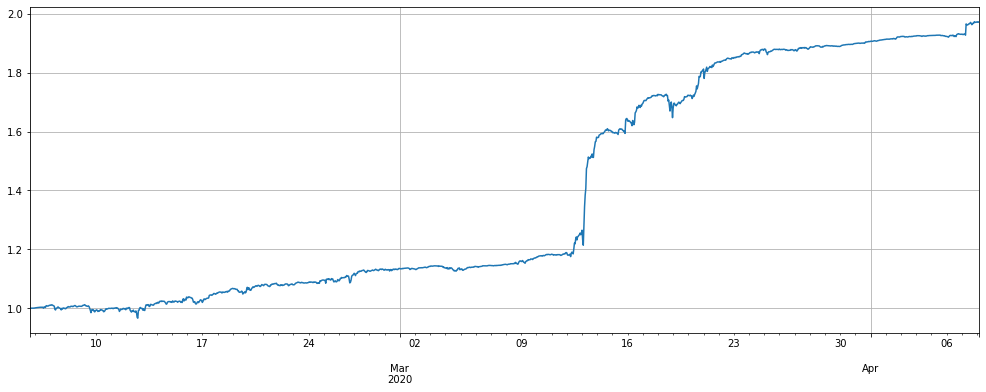

In [246]:
(stragey_2d.df['total']/stragey_2d.initial_balance).plot(figsize=(17,6),grid = True);
#(stragey_2c.df['total']/stragey_2c.initial_balance).plot(figsize=(17,6),grid = True);

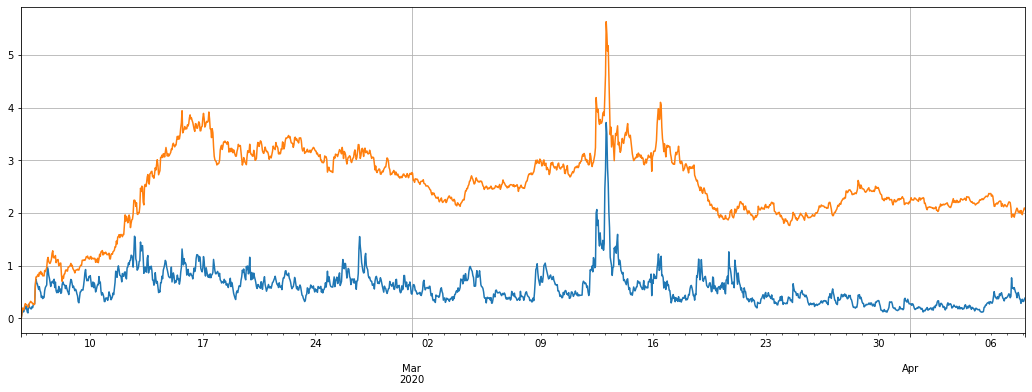

In [247]:
stragey_2d.df['leverage'].plot(figsize=(18,6),grid = True);
stragey_2b.df['leverage'].plot(figsize=(18,6),grid = True); #筛选币种策略杠杆

In [228]:
pd.DataFrame(stragey_2d.account).T.apply(lambda x:round(x,3))

,realised_profit,margin,unrealised_profit,total,leverage,fee,amount,hold_price,value,price
USDT,2341.718,82.776,-4.166,12332.258,0.108,1134.452,NaN,NaN,NaN,NaN
ETC,176.759,2.964,-0.720,NaN,NaN,54.890,-10.490,5.651,60.000,5.720
XLM,-66.953,1.500,0.000,NaN,NaN,40.644,596.066,0.050,30.000,0.050
XMR,1.846,3.000,0.000,NaN,NaN,53.261,1.034,58.020,60.000,58.020
QTUM,183.606,4.479,0.429,NaN,NaN,35.068,63.380,1.413,90.000,1.420
ATOM,45.535,1.472,1.080,NaN,NaN,60.876,12.616,2.333,30.517,2.419
BAT,70.323,-0.000,0.000,NaN,NaN,50.697,0.000,0.170,0.000,0.170
VET,334.754,5.881,2.372,NaN,NaN,53.755,30534.351,0.004,120.000,0.004
TRX,139.098,4.443,1.136,NaN,NaN,43.535,6564.551,0.014,90.000,0.014
ADA,49.083,4.479,0.423,NaN,NaN,38.727,2452.984,0.037,90.000,0.037


有筛选币的情况会怎样，还是同样的参数，前期的收益表现更好，回撤更小，但收益稍低。因此还是推荐筛选的。

In [199]:
#price_usdt_btc_norm2 = price_usdt_btc/price_usdt_btc.rolling(50).mean()
price_usdt_btc_norm2 = price_usdt_btc/price_usdt_btc.ewm(alpha=0.05).mean()
trade_symbols = list(set(symbols)-set(['LINK','XTZ','BCH', 'ETH']))#剩余的币种
price_usdt_btc_norm_mean = price_usdt_btc_norm2[trade_symbols].mean(axis=1)
e = Exchange(trade_symbols,initial_balance=10000,commission=0.0005,log=False)
trade_value = 300
for row in price_usdt.iloc[:].iterrows():
    e.Update(row[0], row[1])
    empty_value = 0
    for symbol in trade_symbols:
        price = row[1][symbol]
        if np.isnan(price):
            continue
        diff = price_usdt_btc_norm2.loc[row[0],symbol] - price_usdt_btc_norm_mean[row[0]]
        aim_value = -trade_value*round(diff/0.01,1)
        now_value = e.account[symbol]['value']*np.sign(e.account[symbol]['amount'])
        empty_value += now_value
        if aim_value - now_value > 20:
            e.Buy(symbol, price, round((aim_value - now_value)/price, 6),round(e.account[symbol]['realised_profit']+e.account[symbol]['unrealised_profit'],2))
        if aim_value - now_value < -20:
            e.Sell(symbol, price, -round((aim_value - now_value)/price, 6),round(e.account[symbol]['realised_profit']+e.account[symbol]['unrealised_profit'],2))
stragey_2e = e

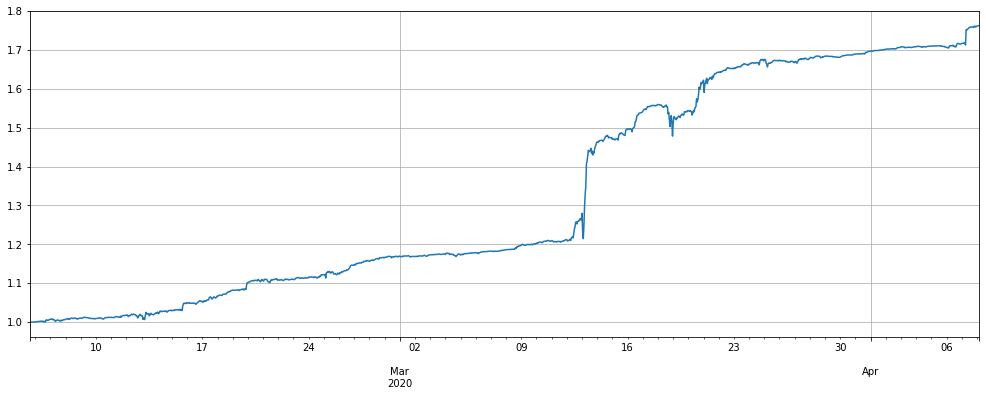

In [200]:
#(stragey_2d.df['total']/stragey_2d.initial_balance).plot(figsize=(17,6),grid = True);
(stragey_2e.df['total']/stragey_2e.initial_balance).plot(figsize=(17,6),grid = True);

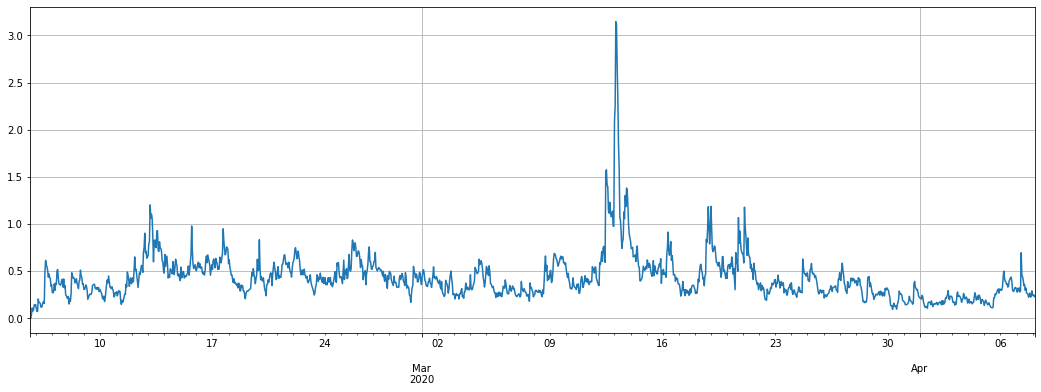

In [192]:
stragey_2e.df['leverage'].plot(figsize=(18,6),grid = True);

In [193]:
pd.DataFrame(stragey_2e.account).T.apply(lambda x:round(x,3))

,realised_profit,margin,unrealised_profit,total,leverage,amount,hold_price,value,price
USDT,7635.210,188.662,0.455,17624.159,0.228,NaN,NaN,NaN,NaN
ETC,485.916,4.500,-0.000,NaN,NaN,-15.734,5.720,90.0,5.720
XLM,-359.482,1.474,-0.513,NaN,NaN,-596.066,0.049,30.0,0.050
XMR,457.349,22.260,4.794,NaN,NaN,7.756,57.402,450.0,58.020
DASH,244.654,2.887,2.265,NaN,NaN,0.804,71.841,60.0,74.660
QTUM,1277.073,7.500,0.000,NaN,NaN,105.634,1.420,150.0,1.420
ATOM,-30.950,1.483,-0.336,NaN,NaN,-12.402,2.392,30.0,2.419
LTC,-31.417,8.817,-3.651,NaN,NaN,-3.856,45.733,180.0,46.680
BAT,477.158,27.264,-24.723,NaN,NaN,-3349.001,0.163,570.0,0.170
NEO,-60.144,2.938,1.243,NaN,NaN,7.533,7.800,60.0,7.965


## 参数的优化

指数移动平局的Alpha参数，设置的越大，基准价格跟踪越敏感，交易的越少，最终持仓也会越低，降低了杠杆，但会降低收益，降低最大回撤，可以加大成交量，具体需要根据回测结果自己权衡。

由于回测是1hK线，只能一小时更新一次，实盘可以更快的更新，需要综合权衡具体设置多少。

这是优化的结果：

In [235]:
for Alpha in [i/100 for i in range(1,30)]:
    #price_usdt_btc_norm2 = price_usdt_btc/price_usdt_btc.rolling(20).mean() #普通均线
    price_usdt_btc_norm2 = price_usdt_btc/price_usdt_btc.ewm(alpha=Alpha).mean() #这里和策略一致，用了EMA
    trade_symbols = list(set(symbols))#全币种
    price_usdt_btc_norm_mean = price_usdt_btc_norm2[trade_symbols].mean(axis=1)
    e = Exchange(trade_symbols,initial_balance=10000,commission=0.0005,log=False)
    trade_value = 300
    for row in price_usdt.iloc[:].iterrows():
        e.Update(row[0], row[1])
        empty_value = 0
        for symbol in trade_symbols:
            price = row[1][symbol]
            if np.isnan(price):
                continue
            diff = price_usdt_btc_norm2.loc[row[0],symbol] - price_usdt_btc_norm_mean[row[0]]
            aim_value = -trade_value*round(diff/0.01,1)
            now_value = e.account[symbol]['value']*np.sign(e.account[symbol]['amount'])
            empty_value += now_value
            if aim_value - now_value > 20:
                e.Buy(symbol, price, round((aim_value - now_value)/price, 6),round(e.account[symbol]['realised_profit']+e.account[symbol]['unrealised_profit'],2))
            if aim_value - now_value < -20:
                e.Sell(symbol, price, -round((aim_value - now_value)/price, 6),round(e.account[symbol]['realised_profit']+e.account[symbol]['unrealised_profit'],2))
    stragey_2d = e
    # 分别是最终净值，初始最大回测，最终持仓大小,手续费
    print(Alpha, round(stragey_2d.account['USDT']['total'],1), round(1-stragey_2d.df['total'].min()/stragey_2d.initial_balance,2),round(pd.DataFrame(stragey_2d.account).T['value'].sum(),1),round(stragey_2d.account['USDT']['fee']))

0.01 21116.2 0.14 15480.0 2178.0
0.02 20555.6 0.07 12420.0 2184.0
0.03 20279.4 0.06 9990.0 2176.0
0.04 20021.5 0.04 8580.0 2168.0
0.05 19719.1 0.03 7740.0 2157.0
0.06 19616.6 0.03 7050.0 2145.0
0.07 19344.0 0.02 6450.0 2133.0
0.08 19174.0 0.02 6120.0 2117.0
0.09 18988.4 0.01 5670.0 2104.0
0.1 18734.8 0.01 5520.0 2090.0
0.11 18532.7 0.01 5310.0 2078.0
0.12 18354.2 0.01 5130.0 2061.0
0.13 18171.7 0.01 4830.0 2047.0
0.14 17960.4 0.01 4770.0 2032.0
0.15 17779.8 0.01 4531.3 2017.0
0.16 17570.1 0.01 4441.3 2003.0
0.17 17370.2 0.01 4410.0 1985.0
0.18 17203.7 0.0 4320.0 1971.0
0.19 17016.9 0.0 4290.0 1955.0
0.2 16810.6 0.0 4230.6 1937.0
0.21 16664.1 0.0 4051.3 1921.0
0.22 16488.2 0.0 3930.6 1902.0
0.23 16378.9 0.0 3900.6 1887.0
0.24 16190.8 0.0 3840.0 1873.0
0.25 15993.0 0.0 3781.3 1855.0
0.26 15828.5 0.0 3661.3 1835.0
0.27 15673.0 0.0 3571.3 1816.0
0.28 15559.5 0.0 3511.3 1800.0
0.29 15416.4 0.0 3481.3 1780.0
